# Vamos a probar con datos de verdad

In [16]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode
from sklearn.metrics import accuracy_score

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers

%matplotlib inline

base_dir = os.path.expanduser('~/.keras/datasets/')

In [17]:
def suplot_image(dataset, clas, image, ax):
    img = plt.imread(os.path.join(base_dir, dataset,'train', clas, image))
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(clas)

Ahora vamos a intentar clasificar un dataset hecho con imágenes más complicadas. 

Hemos subido los siguientes datasets para que probéis.

FileNotFoundError: [Errno 2] No such file or directory: '/home/bscuser/.keras/datasets/muffinorchihuaha/train/chihuahua/00000013.jpg'

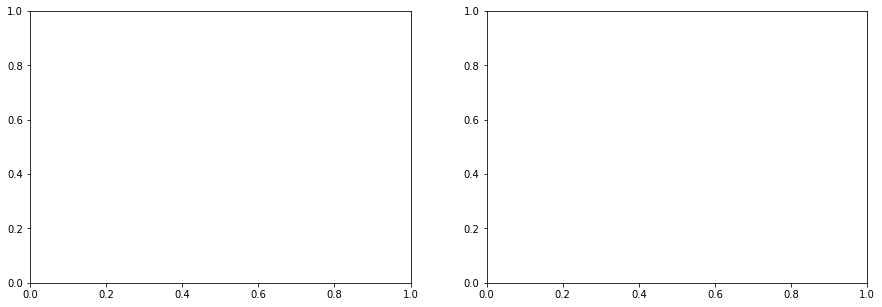

In [18]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
suplot_image('muffinorchihuaha', 'chihuahua', '00000013.jpg', axes[0])
suplot_image('muffinorchihuaha', 'muffin', '00000012.jpg', axes[1])
fig.suptitle('Muffins vs Chihuahua');

#fig, axes = plt.subplots(1,2, figsize=(15,5))
#suplot_image('alien-vs-predator-images', 'alien', '11.jpg', axes[0])
#suplot_image('alien-vs-predator-images', 'predator', '10.jpg', axes[1])
#fig.suptitle('Alien vs Predator');

#fig, axes = plt.subplots(1,3, figsize=(15,5))
#suplot_image('animal-image-datasetdog-cat-and-panda', 'cats', 'cats_00119.jpg', axes[0])
#suplot_image('animal-image-datasetdog-cat-and-panda', 'dogs', 'dogs_00021.jpg', axes[1])
#suplot_image('animal-image-datasetdog-cat-and-panda', 'panda', 'panda_00005.jpg', axes[2])
#fig.suptitle('Cats vs Dogs vs Pandas');

#fig, axes = plt.subplots(1,3, figsize=(15,5))
#suplot_image('memes-classified-and-labelled', 'change_my_mind', 'is2plzpw6b521_redt.jpg', axes[0])
#suplot_image('memes-classified-and-labelled', 'afraid_to_ask_andy', 'xpfjp1zczo221_redt.jpg', axes[1])
#suplot_image('memes-classified-and-labelled', 'coma_patient', 'cskul964xr511_redt.jpg', axes[2])
#fig.suptitle('Memes!');

El objetivo de este notebook es que elijáis uno e intentéis obtener la mejor accuracy posible. 

Aviso: No todos los datasets son igual de fáciles. 

In [5]:
dataset_name = 'muffinorchihuaha'
#dataset_name = "alien-vs-predator-images"
#dataset_name = 'animal-image-datasetdog-cat-and-panda'
#dataset_name = 'memes-classified-and-labelled'

train_dir= os.path.join(base_dir,dataset_name, "train")
validation_dir=os.path.join(base_dir, dataset_name, "validation")
categorias = os.listdir(train_dir)
print('Muestra de las categorías:', categorias[:5])

Muestra de las categorías: ['chihuahua', 'muffin']


Primero vamos a ver que forma tiene el dataset:

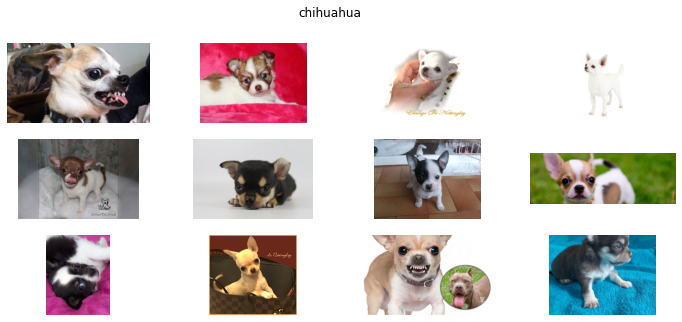

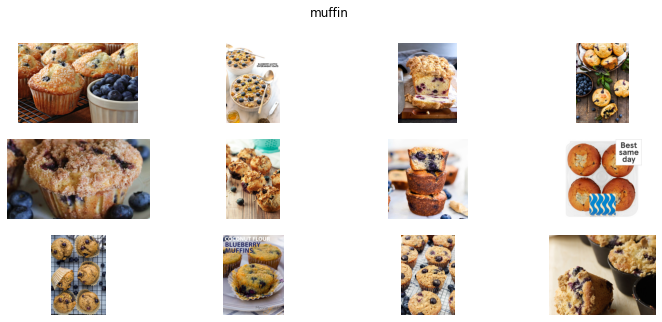

In [6]:
for category in os.listdir(train_dir)[:3]:
    fig, _ = plt.subplots(3,4,figsize=(12,5))
    fig.suptitle(category)
    for k, v in enumerate(os.listdir(train_dir + '/'+category)[:12]):
        img = plt.imread(train_dir + '/'+category+'/'+v)
        plt.subplot(3, 4, k+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

Para entrenar un modelo vamos a necesitar que todas las imágenes tengan el mismo tamaño. 

No todas las imágenes tienen el mismo tamaño, así que vamos a ver que tamaños tienen (en pixels) para poder elegir un tamaño que tenga sentido a la hora de re-dimensionarlas. 

In [7]:
for category in os.listdir(train_dir)[:3]:
    x_shapes = []
    y_shapes = []
    for k, v in enumerate(os.listdir(train_dir + '/'+category)[:12]):
        img = plt.imread(train_dir + '/'+category+'/'+v)
        x_shapes.append(img.shape[0])
        y_shapes.append(img.shape[1])
    print('{}:\n\tTamaño máximo:{} ancho, {} alto \n\tTamaño mínimo:{} ancho, {} alto \n\tTamaño más común:{} ancho, {} alto '.format(category,max(x_shapes),max(y_shapes),min(x_shapes),min(y_shapes),mode(x_shapes)[0][0], mode(y_shapes)[0][0]))

chihuahua:
	Tamaño máximo:1387 ancho, 1523 alto 
	Tamaño mínimo:240 ancho, 240 alto 
	Tamaño más común:600 ancho, 400 alto 
muffin:
	Tamaño máximo:1200 ancho, 915 alto 
	Tamaño mínimo:315 ancho, 540 alto 
	Tamaño más común:315 ancho, 800 alto 


Con esta información elegimos un ancho y un alto para redimensionar. También re-escalaremos las imágenes para que todos los pixels tengan valores entre 0 y 1.

Para leer los datos usaremos un generador de datos de keras. Esta clase se encarga de cargar en memoria las imágenes durante el entrenamiento. 

`datagen.flow_from_directory` Tiene muchos parámetros de pre-procesado de imágenes que os puede interesar mirar: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [8]:
datagen=ImageDataGenerator(rescale=1.0/255.0) # Re-escalamos para que los pixels tengan valores < 1

# Este es el valor por defecto, pero no tiene por que ser el mejor.
ancho_img = 100
alto_img = 100

trainDatagen=datagen.flow_from_directory(train_dir,
                                 target_size=(ancho_img,alto_img),
                                 batch_size=50,
                                 class_mode='categorical')
valDatagen=datagen.flow_from_directory(validation_dir,
                                      target_size=(ancho_img,alto_img),
                                      batch_size=10,
                                      class_mode='categorical', shuffle=False)

num_clases = valDatagen.num_classes

Found 512 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Os hemos puesto un modelo sencillo para que tengáis algo con lo que empezar. Podéis probar a cambiar la arquitectura, el optimizer, la loss... 

Hay muchísimos tipos de layers, podéis mirar de buscar layers que añadan regularización al modelo. Un buen punto por donde empezar sería añadir Dropout al modelo.

* Losses: https://www.tensorflow.org/api_docs/python/tf/keras/losses
* Optimizers: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
* Layers: https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [9]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(ancho_img, alto_img, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_clases, activation='softmax'))
print(model.summary())

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 99, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 76832)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9834624   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 9,835,298
Trainable params: 9,835,298
Non-trainable params: 0
_________________________________________________________________
None


Ahora entrenamos nuestro modelo... 

In [10]:
history=model.fit_generator(trainDatagen,validation_data=valDatagen,epochs=10,verbose=1)

/home/bscuser/.pyenv/versions/3.7.1/envs/bojos/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
 2/11 [====>.........................] - ETA: 5s - loss: 16.7570 - accuracy: 0.5000

/home/bscuser/.pyenv/versions/3.7.1/envs/bojos/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11/11 [==============================] - 8s 668ms/step - loss: 6.7212 - accuracy: 0.5488 - val_loss: 3.5621 - val_accuracy: 0.5000
Epoch 2/10
11/11 [==============================] - 8s 665ms/step - loss: 1.8893 - accuracy: 0.4785 - val_loss: 1.8286 - val_accuracy: 0.5000
Epoch 3/10
11/11 [==============================] - 7s 647ms/step - loss: 0.8931 - accuracy: 0.6113 - val_loss: 0.4965 - val_accuracy: 0.6750
Epoch 4/10
11/11 [==============================] - 7s 651ms/step - loss: 0.4096 - accuracy: 0.8262 - val_loss: 0.4591 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 7s 662ms/step - loss: 0.3238 - accuracy: 0.8613 - val_loss: 0.2566 - val_accuracy: 0.9750
Epoch 6/10
11/11 [==============================] - 7s 647ms/step - loss: 0.2304 - accuracy: 0.9160 - val_loss: 0.1755 - val_accuracy: 0.9500
Epoch 7/10
11/11 [==============================] - 7s 646ms/step - loss: 0.2111 - accuracy: 0.9219 - val_loss: 0.1621 - val_accuracy: 0.9500
Epoch 8/10
11/11 

Vamos a analizar los resultados, primero pintamos la evolución de la loss y la acuracy en los epoch.

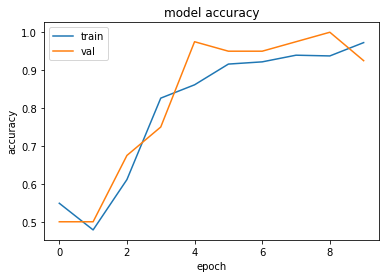

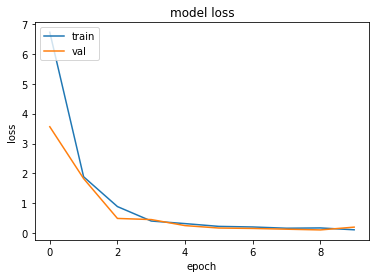

In [11]:
acc_plot = plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

loss_plot = plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

Ahora se puede calcular la accuracy de dos formas diferentes: o usamos evaluate directamente sobre el generador o la calculamos a mano.

De la segunda forma también podemos calcular una matriz de confusión.

In [1]:
score = model.evaluate_generator(valDatagen)

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

NameError: name 'model' is not defined

In [13]:
clases_2_codigo = valDatagen.class_indices
codigo_2_clases = {k:v for v,k in clases_2_codigo.items()}

y_pred = model.predict_generator(valDatagen)
y_pred = np.argmax(y_pred, axis=1)
y_pred_clases = [codigo_2_clases[y] for y in  y_pred]

y_real_clases = [codigo_2_clases[y] for y in  valDatagen.classes]

real_vs_predicted = pd.DataFrame({'real':y_real_clases, 'predicted':y_pred_clases})

accuracy_score(y_real_clases, y_pred_clases);

/home/bscuser/.pyenv/versions/3.7.1/envs/bojos/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


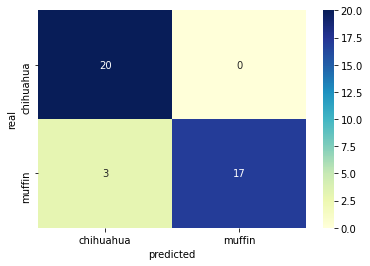

In [14]:
plt.figure(figsize=(6,4))
sns.heatmap(pd.crosstab(real_vs_predicted['real'], real_vs_predicted['predicted']),annot=True, cmap="YlGnBu", fmt='g');